

# **Proyecto C: Optimización en la Planificación de Rutas Nacionales y Estrategia de Recarga para Logistico**


**Facultad de ingeniería**

Departamento de Ingeniería de Sistemas y Computación

Universidad de los Andes

**ISIS-3302:** Modelado, Optimización y Simulación

*   

*   Luisa Gabriela Hernández Pérez

*   Adriana Sofia Rozo Cepeda.


## Utils

In [1]:
%%capture
%pip install networkx matplotlib
%pip install haversine folium
%pip install seaborn
%pip install amplpy pyomo -q
%python -m amplpy.modules install coin highs scip gcg -q


In [2]:
from haversine import haversine
import matplotlib.pyplot as plt
from amplpy import modules
from pyomo.environ import *
import pandas as pd
import folium
import requests
import itertools

In [14]:
import requests
from haversine import haversine
from itertools import product

def get_coordinates(nodo, centros, clientes):
    """
    Devuelve las coordenadas (latitud, longitud) de un nodo, ya sea un centro o un cliente.
    """
    if nodo in centros:
        return centros[nodo]["lat"], centros[nodo]["lon"]
    else:
        return clientes[nodo]["lat"], clientes[nodo]["lon"]


def build_osrm_url(lat1, lon1, lat2, lon2):
    """
    Construye la URL para la consulta a la API pública de OSRM.

    Args:
        lat1, lon1, lat2, lon2 (float): Coordenadas geográficas de los puntos origen y destino.

    Returns:
        str: URL completa para la petición GET.
    """
    base = "http://router.project-osrm.org/route/v1/driving/"
    coords = f"{lon1},{lat1};{lon2},{lat2}"
    return base + coords

def get_route_info(lat1, lon1, lat2, lon2):
    """
    Obtiene información de ruta entre dos puntos usando OSRM.
    Si falla, retorna una distancia geodésica y una línea recta como fallback.

    Args:
        lat1, lon1, lat2, lon2 (float): Coordenadas de los puntos origen y destino.

    Returns:
        tuple: (distancia en km, polilínea de la ruta en formato [[lat, lon], ...])
    """
    url = build_osrm_url(lat1, lon1, lat2, lon2)
    params = {
        "overview": "full",
        "geometries": "geojson"
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        if "routes" in data and data["routes"]:
            route = data["routes"][0]
            distance = route["distance"] / 1000.0  # metros a km
            # OSRM da [lon, lat], se invierte para matplotlib/folium
            polyline = [[lat, lon] for lon, lat in route["geometry"]["coordinates"]]
            return distance, polyline
        else:
            raise ValueError("No se encontró una ruta.")
    except Exception as e:
        print("Error al obtener ruta vía OSRM:", e)
        fallback_distance = haversine((lat1, lon1), (lat2, lon2))
        return fallback_distance, [[lat1, lon1], [lat2, lon2]]

def calcular_distancias_y_geometrias(centros, clientes, get_route_fn):
    """
    Calcula las distancias y rutas entre todos los pares de nodos válidos,
    usando la función de obtención de ruta especificada.

    Args:
        centros (dict): Diccionario con información de centros de distribución.
        clientes (dict): Diccionario con información de clientes.
        get_route_fn (callable): Función que recibe lat/lon de dos puntos y devuelve (distancia, ruta).

    Returns:
        tuple: 
            - distancias: diccionario {(i,j): distancia_km}
            - geometries: diccionario {(i,j): polilínea}
    """
    nodos = list(centros.keys()) + list(clientes.keys())
    distancias = {}
    geometries = {}

    # Recorremos todas las combinaciones de nodos, excepto centro-centro y i == j
    for i, j in product(nodos, repeat=2):
        if i != j and not (i in centros and j in centros):
            lat_i, lon_i = get_coordinates(i, centros, clientes)
            lat_j, lon_j = get_coordinates(j, centros, clientes)

            # Obtener distancia y geometría de ruta
            distancia, ruta = get_route_fn(lat_i, lon_i, lat_j, lon_j)
            distancias[(i, j)] = distancia
            geometries[(i, j)] = ruta

    return distancias, geometries


In [15]:
import folium

def visualizar_rutas_folium(model, puertos, municipios, geometries, colores_vehiculos=None,
                             nombre_archivo="./resultados/ruta_optima_nacional.html"):
    """
    Visualiza las rutas óptimas obtenidas por el modelo de optimización usando un mapa de Folium.

    Args:
        model (ConcreteModel): Modelo de Pyomo con variables x[i,j,v] que indican rutas utilizadas por vehículo.
        puertos (dict): Diccionario con coordenadas de los puertos. Ej: { 'P1': {'lat': .., 'lon': ..}, ... }
        municipios (dict): Diccionario con coordenadas de los municipios (clientes). Mismo formato que puertos.
        geometries (dict): Diccionario con las rutas reales entre pares (i, j), en formato [[lat, lon], ...]
        colores_vehiculos (dict, optional): Colores por vehículo para diferenciar rutas. Ej: { 'V1': 'red' }
        nombre_archivo (str): Ruta donde se guardará el archivo HTML generado.

    Returns:
        None. Guarda un archivo HTML interactivo y lo notifica por consola.
    """
    if colores_vehiculos is None:
        colores_vehiculos = {}

    # === Centro del mapa: promedio de coordenadas ===
    all_coords = [(puertos[n]["lat"], puertos[n]["lon"]) for n in puertos] + \
                 [(municipios[n]["lat"], municipios[n]["lon"]) for n in municipios]
    mean_lat = sum(lat for lat, _ in all_coords) / len(all_coords)
    mean_lon = sum(lon for _, lon in all_coords) / len(all_coords)

    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=6)

    # === Marcadores para puertos ===
    for p in puertos:
        folium.Marker(
            location=[puertos[p]["lat"], puertos[p]["lon"]],
            popup=f"Puerto {p}",
            icon=folium.Icon(color='green', icon='ship', prefix='fa')
        ).add_to(m)

    # === Marcadores para municipios ===
    for mnp in municipios:
        folium.Marker(
            location=[municipios[mnp]["lat"], municipios[mnp]["lon"]],
            popup=f"Municipio {mnp}",
            icon=folium.Icon(color='blue', icon='user', prefix='fa')
        ).add_to(m)

    # === Dibujar rutas utilizadas por vehículos ===
    for v in model.V:
        for (i, j) in model.A:
            var = model.x[i, j, v]
            if var.value is not None and var.value > 0.5:
                polyline = geometries.get((i, j))
                if polyline:
                    folium.PolyLine(
                        locations=polyline,
                        color=colores_vehiculos.get(v, 'black'),
                        weight=5,
                        opacity=0.8,
                        popup=f"Ruta {i} → {j} (Vehículo {v})"
                    ).add_to(m)

    # === Guardar el resultado ===
    m.save(nombre_archivo)
    print(f"El mapa de rutas ha sido guardado en '{nombre_archivo}'.")


In [41]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os

def visualizar_rutas_estatica(model, puertos, municipios, geometries,
                               colores_vehiculos=None,
                               titulo="Rutas Nacionales",
                               ruta_salida="../visual-results/mapa_estatico_caso1.png"):
    """
    Visualización estática con matplotlib de las rutas asignadas por el modelo.

    Args:
        model: Modelo Pyomo con variables x[i,j,v].
        puertos (dict): Diccionario con lat/lon de puertos.
        municipios (dict): Diccionario con lat/lon de municipios.
        geometries (dict): Diccionario de polilíneas [(lat, lon)] por arco (i,j).
        colores_vehiculos (dict): Colores por ID de vehículo.
        titulo (str): Título del gráfico.
        ruta_salida (str): Ruta donde guardar la imagen PNG.
    """
    if colores_vehiculos is None:
        colores_vehiculos = {}

    os.makedirs(os.path.dirname(ruta_salida), exist_ok=True)

    plt.figure(figsize=(10, 10))

    # === Dibujar nodos: puertos
    for p_id, p in puertos.items():
        plt.plot(p['lon'], p['lat'], 's', color='green', markersize=10)
        plt.text(p['lon'], p['lat'] + 0.02, p_id, fontsize=9, ha='center')

    # === Dibujar nodos: municipios
    for c_id, c in municipios.items():
        plt.plot(c['lon'], c['lat'], 'o', color='blue', markersize=6)
        plt.text(c['lon'], c['lat'] + 0.015, c_id, fontsize=8, ha='center')

    # === Dibujar rutas por vehículo
    for v in model.V:
        color = colores_vehiculos.get(v, 'black')
        for (i, j) in model.A:
            if model.x[i, j, v].value is not None and model.x[i, j, v].value > 0.5:
                polyline = geometries.get((i, j))
                if polyline:
                    lats, lons = zip(*polyline)
                    plt.plot(lons, lats, '-', color=color, linewidth=2, alpha=0.8)

    # === Leyenda profesional con colores reales
    leyenda = [
        Line2D([0], [0], color=colores_vehiculos.get(v, 'black'), lw=3, label=f'Vehículo {v}')
        for v in model.V
    ]
    plt.legend(handles=leyenda, title='Vehículos', loc='best', fontsize=8)

    # === Estética y guardado
    plt.title(titulo)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(ruta_salida, dpi=300)
    plt.show()
    print(f"Mapa estático guardado en: {ruta_salida}")


## Caso Base

In [16]:
from pyomo.environ import *

class ModeloCasoBase:
    def __init__(self, puertos, municipios, vehiculos, parametros, distancias):
        self.puertos = puertos
        self.municipios = municipios
        self.vehiculos = vehiculos
        self.parametros = parametros
        self.distancias = distancias
        self.model = ConcreteModel()
        self._build_model()
        
    def _build_model(self):
        model = self.model
        puertos = self.puertos
        municipios = self.municipios
        vehiculos = self.vehiculos
        distancias = self.distancias
        nodos = list(puertos.keys()) + list(municipios.keys())
        
        # === Conjuntos ===
        model.N = Set(initialize=nodos)  
        model.M = Set(initialize=municipios.keys())  
        model.P = Set(initialize=puertos.keys()) 
        model.V = Set(initialize=list(vehiculos.keys()))
        model.A = Set(
            within=(model.P | model.M) * (model.P | model.M),
            initialize=[(i, j) for i in (set(puertos.keys()) | set(municipios.keys()))
                        for j in (set(puertos.keys()) | set(municipios.keys()))
                        if i != j and not (i in puertos and j in puertos)]
        )

        
        # === Parámetros ===
        model.dem_m = Param(model.M, initialize={m: municipios[m]["demanda"] for m in model.M})
        model.dist_ij = Param(model.A, initialize=distancias)
        model.cap_v = Param(model.V, initialize={v: vehiculos[v]["capacidad"] for v in vehiculos})
        model.rango_v = Param(model.V, initialize={v: vehiculos[v]["rango"] for v in vehiculos})

        # === Variables ===
        model.x = Var(model.A, model.V, within=Binary) 
        model.u = Var(model.M, model.V, within=NonNegativeIntegers, bounds=(0, len(model.M | model.P) - 1))

        
        # === Función Objetivo ===
        def funcion_objetivo(model):
            return sum(
                model.x[i, j, v] * model.dist_ij[i, j] *
                (self.parametros["ft"] + self.parametros["m"] + self.parametros["tk"] * self.parametros["fi"])
                for v in model.V for (i, j) in model.A
            )

        model.objetivo = Objective(rule=funcion_objetivo, sense=minimize)

        
        # === Restricciones ===

        def capacidad_vehiculos_rule(model, v):
            return sum(model.x[i, m, v] * model.dem_m[m] for (i, m) in model.A if m in model.M) <= model.cap_v[v]
        model.capacidad_vehiculos = Constraint(model.V, rule=capacidad_vehiculos_rule)

        def visitar_municipios_rule(model, m):
            return sum(model.x[i, m, v] for v in model.V for i in nodos if (i, m) in model.A) == 1
        model.visitar_municipios = Constraint(model.M, rule=visitar_municipios_rule)

        def autonomia_vehiculos_rule(model, v):
            return sum(model.dist_ij[i, j] * model.x[i, j, v] for (i, j) in model.A) <= model.rango_v[v]
        model.autonomia_vehiculos = Constraint(model.V, rule=autonomia_vehiculos_rule)

        def conservacion_flujo_rule(model, i, v):
            salida = sum(model.x[i, j, v] for j in nodos if (i, j) in model.A)
            entrada = sum(model.x[j, i, v] for j in nodos if (j, i) in model.A)
            return salida - entrada == 0 if i in model.M else salida - entrada <= 1
        model.conservacion_flujo = Constraint(nodos, model.V, rule=conservacion_flujo_rule)

        def subtours_elimination_rule(model, i, j, v):
            if i != j and i in model.M and j in model.M:
                return model.u[i, v] - model.u[j, v] + len(nodos) * model.x[i, j, v] <= len(nodos) - 1
            else:
                return Constraint.Skip
        model.subtours_elimination = Constraint(model.M, model.M, model.V, rule=subtours_elimination_rule)

        def salida_unica_rule(model, v):
            return sum(model.x[p, j, v] for p in model.P for j in model.M if (p, j) in model.A) == 1
        model.salida_unica = Constraint(model.V, rule=salida_unica_rule)

        def retorno_puerto_rule(model, v):
            return sum(model.x[i, p, v] for p in model.P for i in model.M if (i, p) in model.A) >= 1
        model.retorno_puerto = Constraint(model.V, rule=retorno_puerto_rule)


    def solve(self, solver_name="glpk"):
        solver = SolverFactory(solver_name)
        return solver.solve(self.model, timelimit = 450)
    
    def print_routes(self):
        model = self.model
        print("Asignaciones ordenadas por vehículo:\n")
        
        for v in model.V:
            salida = [(i, j) for (i, j) in model.A
                    if i in model.P and model.x[i, j, v].value == 1]
            
            if not salida:
                print(f"Vehículo {v}: no sale de ningún puerto")
                continue

            start_arc = salida[0]
            ruta = [start_arc[0]]
            actual = start_arc[1]
            ruta.append(actual)

            while actual not in model.P:
                siguiente = next(
                    (j for (i, j) in model.A if i == actual and model.x[i, j, v].value == 1),
                    None
                )
                if siguiente is None:
                    break
                ruta.append(siguiente)
                actual = siguiente

            print(f"Vehículo {v}:")
            for u, w in zip(ruta, ruta[1:]):
                print(f"  - {u} -> {w}")
            print()


## Carga de datos

In [17]:
import pandas as pd
vehiculos = pd.read_csv('../data-cases/base-case/vehicles.csv')
municipios = pd.read_csv('../data-cases/base-case/clients.csv')
puertos = pd.read_csv('../data-cases/base-case/depots.csv')
puertos.rename(columns={"Latitude": "tmp", "Longitude": "Latitude", "DepotID": "Longitude", "LocationID": "DepotID"}, inplace=True)
puertos.drop(columns="tmp", inplace=True)

In [18]:
from IPython.display import display, HTML

In [19]:
vehiculos_html = vehiculos.to_html(index=False)
municipios_html = municipios.to_html(index=False)
puertos_html = puertos.to_html(index=False)

html_content = f"""
<div style="display: flex; justify-content: space-around;">
    <div style="margin-right: 5px;">
        <h3>Vehículos</h3>
        {vehiculos_html}
    </div>
    <div>
        <h3>Municipios</h3>
        {municipios_html}
    </div>
     <div>
        <h3>Puertos</h3>
        {puertos_html}
    </div>
</div>
"""

display(HTML(html_content))


In [20]:
puertos_f = {
    f"CD{int(row['DepotID'])}" :{
        "lat": row["Latitude"],
        "lon": row["Longitude"],
    }
    for _, row in puertos.iterrows()
}

puertos_f


{'CD1': {'lat': np.float64(4.743359), 'lon': np.float64(-74.153536)}}

In [21]:
vehiculos_f = {
    f"V{int(row['VehicleID'])}": {
        "capacidad": row["Capacity"],
        "rango": row["Range"]
    }
    for _, row in vehiculos.iterrows()
}

vehiculos_f


{'V1': {'capacidad': np.int64(130), 'rango': np.int64(170)},
 'V2': {'capacidad': np.int64(140), 'rango': np.int64(200)},
 'V3': {'capacidad': np.int64(120), 'rango': np.int64(180)},
 'V4': {'capacidad': np.int64(100), 'rango': np.int64(90)},
 'V5': {'capacidad': np.int64(70), 'rango': np.int64(100)},
 'V6': {'capacidad': np.int64(55), 'rango': np.int64(170)},
 'V7': {'capacidad': np.int64(110), 'rango': np.int64(150)},
 'V8': {'capacidad': np.int64(114), 'rango': np.int64(140)}}

In [22]:
municipios_f = {
    f"C{int(row['ClientID'])}": {
        "demanda": row["Demand"],
        "lat": row["Latitude"],
        "lon": row["Longitude"]
    }
    for _, row in municipios.iterrows()
}

municipios_f

{'C1': {'demanda': np.float64(13.0),
  'lat': np.float64(4.59795431125545),
  'lon': np.float64(-74.09893796560621)},
 'C2': {'demanda': np.float64(15.0),
  'lat': np.float64(4.687820646838871),
  'lon': np.float64(-74.07557103763986)},
 'C3': {'demanda': np.float64(12.0),
  'lat': np.float64(4.70949446000624),
  'lon': np.float64(-74.10708524062704)},
 'C4': {'demanda': np.float64(15.0),
  'lat': np.float64(4.605029068682624),
  'lon': np.float64(-74.09727965657427)},
 'C5': {'demanda': np.float64(20.0),
  'lat': np.float64(4.648463876533332),
  'lon': np.float64(-74.16464148202755)},
 'C6': {'demanda': np.float64(17.0),
  'lat': np.float64(4.662137416953968),
  'lon': np.float64(-74.12083799988112)},
 'C7': {'demanda': np.float64(17.0),
  'lat': np.float64(4.697499030379109),
  'lon': np.float64(-74.02213076607309)},
 'C8': {'demanda': np.float64(20.0),
  'lat': np.float64(4.649416884236942),
  'lon': np.float64(-74.17207549744595)},
 'C9': {'demanda': np.float64(20.0),
  'lat': np.f

## Solve model

Basado en la sección 6 del modelo matemático entregado en la etapa #1 tenemos los parámetros mostrados a continuación.

In [23]:
parametros = {"fi": 12, "ft": 5000, "m": 700, "tk": 1}

In [24]:
distancias, geometries = calcular_distancias_y_geometrias(puertos_f, municipios_f, get_route_info)

modelo2 = ModeloCasoBase(puertos_f, municipios_f, vehiculos_f, parametros, distancias)
modelo2.solve()
modelo2.print_routes()

Asignaciones ordenadas por vehículo:

Vehículo V1:
  - CD1 -> C14
  - C14 -> CD1

Vehículo V2:
  - CD1 -> C13
  - C13 -> C4
  - C4 -> C22
  - C22 -> C1
  - C1 -> C24
  - C24 -> C16
  - C16 -> C10
  - C10 -> C15
  - C15 -> C6
  - C6 -> CD1

Vehículo V3:
  - CD1 -> C21
  - C21 -> C7
  - C7 -> C19
  - C19 -> C2
  - C2 -> CD1

Vehículo V4:
  - CD1 -> C20
  - C20 -> CD1

Vehículo V5:
  - CD1 -> C23
  - C23 -> CD1

Vehículo V6:
  - CD1 -> C12
  - C12 -> CD1

Vehículo V7:
  - CD1 -> C3
  - C3 -> CD1

Vehículo V8:
  - CD1 -> C18
  - C18 -> C17
  - C17 -> C11
  - C11 -> C9
  - C9 -> C5
  - C5 -> C8
  - C8 -> CD1



In [28]:
colores1 = {
    'V1': 'green',
    'V2': 'black',
    'V3': 'blue',
    'V4': 'blue',
    'V5': 'red',
    'V6': 'orange',
    'V7': 'cyan',
    'V8': 'magenta',
}

visualizar_rutas_folium(modelo2.model, puertos_f, municipios_f, geometries, colores1, nombre_archivo="../visual-results/caso_base_solucion.html" )

El mapa de rutas ha sido guardado en '../visual-results/caso_base_solucion.html'.


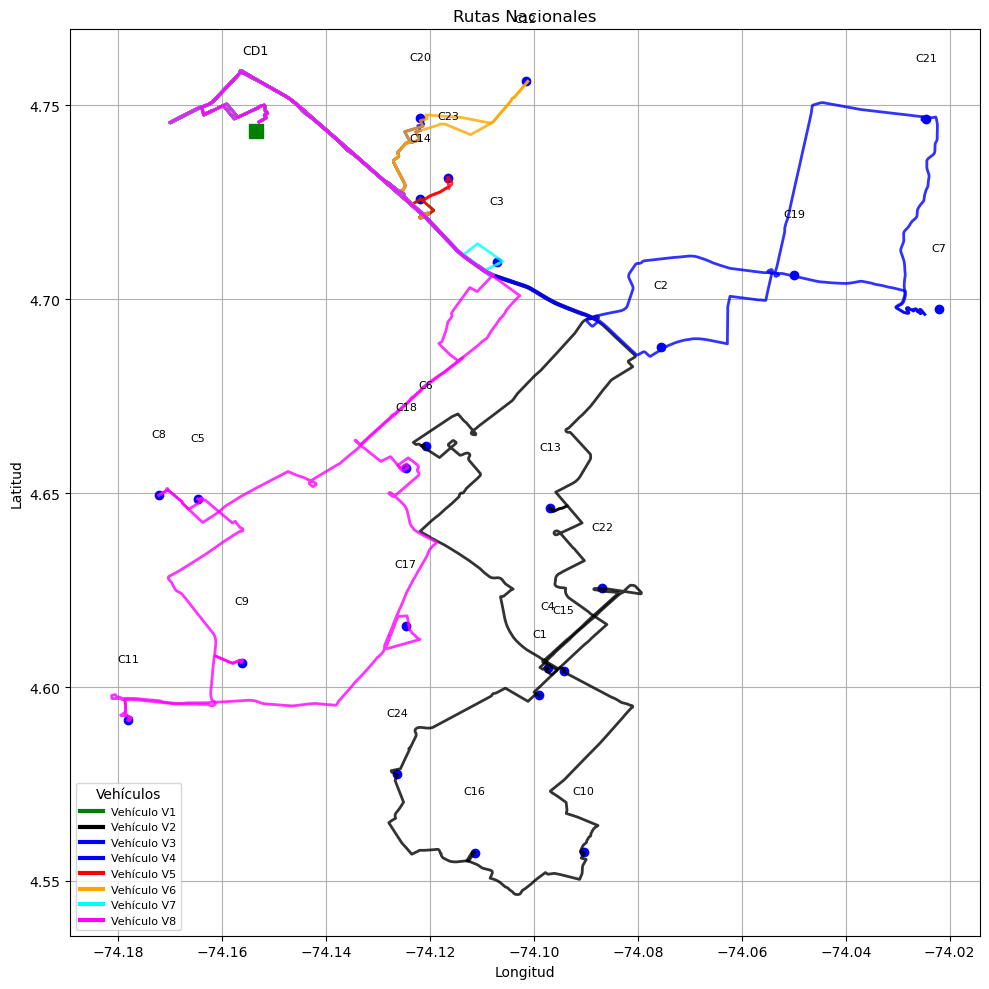

Mapa estático guardado en: ../visual-results/mapa_estatico_caso1.png


In [42]:
visualizar_rutas_estatica(modelo2.model, puertos_f, municipios_f, geometries, colores1)

## Validación

In [39]:
import csv
import os

def exportar_verificacion_caso1(modelo, distancias, vehiculos, municipios,
                                 nombre_archivo="../validation/verificacion_caso1.csv",
                                 parametros=None):
    """
    Genera un archivo de verificación con la información exigida para el Caso Base del Proyecto C.

    Args:
        modelo: Instancia de la clase ModeloCasoBase.
        distancias: Diccionario de distancias {(i, j): distancia_km}
        vehiculos: Diccionario con specs por vehículo (capacidad y rango)
        municipios: Diccionario con demandas y coords
        nombre_archivo: Ruta de salida del archivo CSV
        parametros: Diccionario con parámetros ft, m, tk, fi para el costo total
    """
    
    os.makedirs(os.path.dirname(nombre_archivo), exist_ok=True)

    model = modelo.model
    filas = []

    for v in model.V:
        salida = [(i, j) for (i, j) in model.A if i in model.P and model.x[i, j, v].value == 1]
        if not salida:
            continue

        ruta = [salida[0][0], salida[0][1]]
        actual = salida[0][1]
        while actual not in model.P:
            siguiente = next((j for (i, j) in model.A if i == actual and model.x[i, j, v].value == 1), None)
            if siguiente is None:
                break
            ruta.append(siguiente)
            actual = siguiente

        vehicle_id = v
        load_cap = int(vehiculos[v]['capacidad'])
        fuel_cap = int(vehiculos[v]['rango'])
        route_seq = "-".join(["PTO" if n in model.P else f"MUN{n[1:]}" for n in ruta])
        municipios_visitados = [n for n in ruta if n in model.M]
        num_municipios = len(municipios_visitados)
        demandas = [int(municipios[m]['demanda']) for m in municipios_visitados]
        demandas_str = "-".join(str(d) for d in demandas)
        initial_load = sum(demandas)
        initial_fuel = fuel_cap

        distancia_total = sum(distancias[(ruta[i], ruta[i+1])] for i in range(len(ruta)-1))
        tiempo_total = round(distancia_total, 2)
        costo_total = 0
        if parametros:
            fi, ft, m, tk = parametros['fi'], parametros['ft'], parametros['m'], parametros['tk']
            costo_total = round(distancia_total * (ft + m + tk * fi))

        fila = {
            "VehicleId": vehicle_id,
            "LoadCap": load_cap,
            "FuelCap": fuel_cap,
            "RouteSequence": route_seq,
            "Municipalities": num_municipios,
            "DemandSatisfied": demandas_str,
            "InitialLoad": initial_load,
            "InitialFuel": initial_fuel,
            "Distance": round(distancia_total, 2),
            "Time": round(tiempo_total, 2),
            "TotalCost": costo_total
        }
        filas.append(fila)

    columnas = ["VehicleId", "LoadCap", "FuelCap", "RouteSequence", "Municipalities",
                "DemandSatisfied", "InitialLoad", "InitialFuel", "Distance", "Time", "TotalCost"]

    with open(nombre_archivo, mode='w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=columnas)
        writer.writeheader()
        for fila in filas:
            writer.writerow(fila)

    print(f"Archivo de verificación guardado en: {nombre_archivo}")


In [40]:
exportar_verificacion_caso1(
    modelo2,
    distancias,
    vehiculos_f,
    municipios_f,
    parametros=parametros
)


Archivo de verificación guardado en: ../validation/verificacion_caso1.csv
